In [1]:
import pandas as pd
import json
from datetime import datetime
from datetime import time
import matplotlib.pyplot as plt

## Load Data

In [2]:
time_series_path = 'caltech/California_Garage_01/'

In [3]:
json_path = 'caltech/acndata_sessions.json'

with open(json_path, 'r') as f:
    json_data = json.load(f)

In [4]:
json_data['_items'][2]

{'_id': '5c412c1df9af8b12cb56c282',
 'clusterID': '0039',
 'connectionTime': 'Tue, 01 Jan 2019 21:10:03 GMT',
 'disconnectTime': 'Wed, 02 Jan 2019 02:03:53 GMT',
 'doneChargingTime': 'Wed, 02 Jan 2019 01:18:33 GMT',
 'kWhDelivered': 1.28,
 'sessionID': '2_39_79_377_2019-01-01 21:10:02.892601',
 'siteID': '0002',
 'spaceID': 'CA-325',
 'stationID': '2-39-79-377',
 'timezone': 'America/Los_Angeles',
 'userID': None,
 'userInputs': None}

In [5]:
X = []
Y = []

for session in json_data['_items']:
    time_series_file = session['sessionID'].replace("_", "-" )
    time_series_file = time_series_file.replace(":", "-" )
    time_series_file = time_series_file.replace(".", "-" )
    time_series_file = time_series_file.replace(" ", "T" )
    
    try:
        kWhRequested = session['userInputs'][0]['kWhRequested']
        minutesAvailable = session['userInputs'][0]['minutesAvailable']
        modifiedAt = session['userInputs'][0]['modifiedAt']

        modifiedAt = datetime.strptime(modifiedAt[-12:-4], '%H:%M:%S')
        arrival = modifiedAt
        modifiedstart = arrival.replace(hour=0, minute=0, second=0)
        modifiedAt = abs(modifiedAt - modifiedstart).total_seconds() / 3600.0
        
        milesRequested = session['userInputs'][0]['milesRequested']
        WhPerMile = session['userInputs'][0]['WhPerMile']
        userID = session['userInputs'][0]['userID']
        
        kWhDelivered = session['kWhDelivered']
        disconnectTime = datetime.strptime(session['disconnectTime'][-12:-4], '%H:%M:%S')
        connectionTime = datetime.strptime(session['connectionTime'][-12:-4], '%H:%M:%S')
        minutesStayed = (disconnectTime - connectionTime).total_seconds() / 60.0
        if minutesStayed <0:
            minutesStayed += 60.0 * 24

        time_series_session = pd.read_csv(time_series_path + time_series_file + '.csv.gz', compression='gzip',
                   error_bad_lines=False)
            
        Y.append([kWhRequested, kWhDelivered, minutesAvailable, minutesStayed, modifiedAt, milesRequested, WhPerMile, userID])
        X.append(time_series_session)
        
    except:
        continue

In [6]:
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from matrixprofile.distanceProfile import massDistanceProfile

## Get Tails from X

In [7]:
def get_tails(X,Y):
    
    """ 
    X:= Charging current time-series 
    Y:= Discrete charging data
    """ 
    
    # Get user ID
    ID_list = []
    ID_dict = {}
    for session in range(len(Y)):
        ID_list.append(Y[session][5])
    ID_set = set(ID_list)
    
    for uid in ID_set:
        ID_dict[uid] = []
    
    for session in range(len(Y)):
        ID_dict[Y[session][5]].append(session) 
    
    # Consider user with more than 30 sessions
    sessions_per_user = 30
    selected_ID_list = []
    for k,v in ID_dict.items():
        if len(v) >= sessions_per_user:
            selected_ID_list.append(k)
    
    # Tail extraction parameters
    threshold = 10
    upbound = 15
    lowbound = 0
    duration = 80
    
    all_tails_list = []
    all_labels_list = []
    scaler = StandardScaler()
    
    for uid in selected_ID_list:
        
        X_subset,Y_subset,bp = make_group(uid,X,Y,ID_dict)
        df = pd.concat(X_subset)
        scaled_current =  scaler.fit_transform(df['Charging Current (A)'].to_numpy().reshape(-1, 1))
        # Get a tail template 
        tail_start,tail_end,tail_template = get_template(df,bp,threshold,upbound,lowbound,duration)
        if len(tail_template) < 10:
            continue
        else:
            m = len(tail_template)
            distance_profiles = massDistanceProfile(tail_template, 0, m, scaled_current.ravel())
            selected_pos, selected_id = choose_best_by_group(bp,distance_profiles)
            selected_pos_strict = [i for i in selected_pos if distance_profiles[0][i] < threshold]
            
            for i in range(len(selected_pos)):
                tail_pos = selected_pos[i]
                if distance_profiles[0][tail_pos] < threshold:
                    all_tails_list.append(df['Charging Current (A)'][tail_pos:tail_pos+m].to_numpy())
                    all_labels_list.append(Y_subset[selected_id[i]])
            
        print('Finishing tail extraction for uid ' + str(uid))
    
    return all_tails_list, all_labels_list

In [13]:
all_tails_list, all_labels_list = get_tails(X,Y)

/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 130


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 10


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 140


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 20


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 150


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 30
Finishing tail extraction for uid 160
Finishing tail extraction for uid 38


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 40


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 170


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 300


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 50


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)
/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))


Finishing tail extraction for uid 180


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 60


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 70


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 200


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)
/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))


Finishing tail extraction for uid 80


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 90


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 100


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)
/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))


Finishing tail extraction for uid 110


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 240


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 120


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Finishing tail extraction for uid 250


In [ ]:
len(all_labels_list)

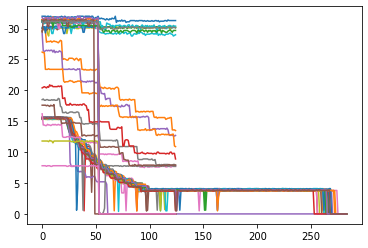

In [131]:
for tail in range(3000,3058):
    plt.plot(all_tails_list[tail])

In [8]:
def make_group(groupid,combined_df,discrete_data,users_dict):
    '''
    Group the time series with the same id into a single time series
    If resampled is true, then each time series will be resampled with a
    a same frequency before grouping (otherwise many redundant samples)
    
    The total number of series is len(list_of_bp)-1
    '''
    list_of_dfs = []
    list_of_bp = [0]
    list_of_discrete_data = []
    ts_len = 0
    for i in users_dict[groupid]:
        tmp = combined_df[i]
        list_of_dfs.append(tmp)
        ts_len += len(tmp.index)
        list_of_bp.append(ts_len)
        list_of_discrete_data.append(discrete_data[i])
        
    return list_of_dfs,list_of_discrete_data,list_of_bp

In [9]:
def choose_best_by_group(bp, distance_profiles):
    
    n = len(bp)-1
    indices = range(len(distance_profiles[0]))
    groups = [[] for i in range(n)]
    for idx in indices:
        tmp = [i for i, x in enumerate(bp[1:]) if idx<= x]
        groups[tmp[0]].append(idx)
        
    selected_pos = []
    selected_id = []
    for group_id in range(len(groups)):
        tmp_id = 0
        tmp_v = np.inf
        if len(groups[group_id]) > 0:
            for id in groups[group_id]:
                if distance_profiles[0][id] < tmp_v:
                    tmp_id = id
                    tmp_v = distance_profiles[0][id]
            selected_pos.append(tmp_id)
            selected_id.append(group_id)
            
    return selected_pos, selected_id

In [10]:
def choose_best(distance_profiles):
    tmp_v = np.inf
    for id in range(len(distance_profiles)):
        if distance_profiles[0][id] < tmp_v:
            tmp_id = id
            tmp_v = distance_profiles[0][id]
    if tmp_v < np.inf:
        if_valid = 1
    else:
        if_valid = 0
        tmp_id = 0
    return tmp_id, if_valid

In [11]:
def extract_by_val(current_list,up=15,low=0):
    '''
    Extract the tails by specified values.
    :param current_list: a pd.Series of current readings with timestamp as index
    :param up: upper bound value
    :param low: lower bound value
    :return: an extracted current_list
    TODO: improve the function to be noise-robust
    Example:
        extract_by_val(current_list_jpl[34])
    '''
    tmp = [i for i, v in enumerate(list(current_list)) if v > up]
    if len(tmp) > 0:
        start_loc = tmp[-1]
    else:
        return 0,0
    tmp = [i for i, v in enumerate(list(current_list)) if (v <= low and i > start_loc)]
    if len(tmp)> 0:
        end_loc = tmp[0]
    else:
        return 0,0
    return start_loc,end_loc

In [12]:
def get_template(df,bp,threshold,upbound,lowbound=0,duration = 80,method='first'):
    # z-norm the whole current series
    scaler = StandardScaler()
    scaled_current =  scaler.fit_transform(df['Charging Current (A)'].to_numpy().reshape(-1, 1))
    # find the first valid tails
    tail_start = 0
    tail_end = 0
    if method =='first':
        i = 0
        while (tail_start == tail_end or (tail_end-tail_start)<duration) and i < (len(bp)-1):
            tail_start, tail_end = extract_by_val(df['Charging Current (A)'][bp[i]:bp[i+1]], upbound, lowbound)
            tail_start += bp[i]
            tail_end += bp[i]
            i += 1
        if i == (len(bp)-1):
            print("fails! no tail found")
            tail_template = []
    tail_template = scaled_current.ravel()[tail_start:tail_end]
    return tail_start,tail_end,tail_template

## Save Data

In [14]:
charging_data = {}
charging_data['X'] = all_tails_list
charging_data['Y'] = all_labels_list

""" 
X:= Charging current time-series 
Y:= Discrete charging data
""" 

' \nX:= Charging current time-series \nY:= Discrete charging data\n'

In [16]:
# write python dict to a file
output = open('charging_data.pkl', 'wb')
pickle.dump(charging_data, output)
output.close()

In [ ]:
# read python dict back from the file
pkl_file = open('charging_data.pkl', 'rb')
output = pickle.load(pkl_file)
pkl_file.close()